# Natural Language Processing - final project

Il CTO ha fornito un dataset di email per realizzare le seguenti attività:
1. **Addestrare un classificatore** per identificare le email SPAM.
1. **Individuare i Topic principali** tra le email classificate come SPAM.
1. **Calcolare la distanza semantica** tra i topics ottenuti per valutare l'eterogeneità dei contenuti delle email SPAM.
1. **Estrarre dalle email NON SPAM** le informazioni sulle Organizzazioni menzionate.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import spacy 
import nltk
from nltk.corpus import stopwords
from gensim.models import LdaMulticore
from sklearn.metrics import classification_report
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB

RANDOM_SEED = 176

In [2]:

URL = "https://raw.githubusercontent.com/ProfAI/natural-language-processing/refs/heads/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv"

#import only useful columns
df = pd.read_csv(URL,usecols=["label","text","label_num"])
df.head()


,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\nthis deal is to ...,0


## Data exploration
In this section a descriptive analysis is performed, in order to investigate about dataset features.

### Missing values
Missing values should be handled somehow, if any.

In [3]:
df.isna().sum()

label        0
text         0
label_num    0
dtype: int64

Good news! Luckly there are no missing values.

### Label
First of all let's check `label` and `label_num` distribution; probably `label_num` has the same meaning of `label` but in an encoded fashion.

One can check it with univariate and multivariate analysis.

In [4]:
print(df["label"].value_counts())
print("-"*20)
print(df["label_num"].value_counts())

label
ham     3672
spam    1499
Name: count, dtype: int64
--------------------
label_num
0    3672
1    1499
Name: count, dtype: int64


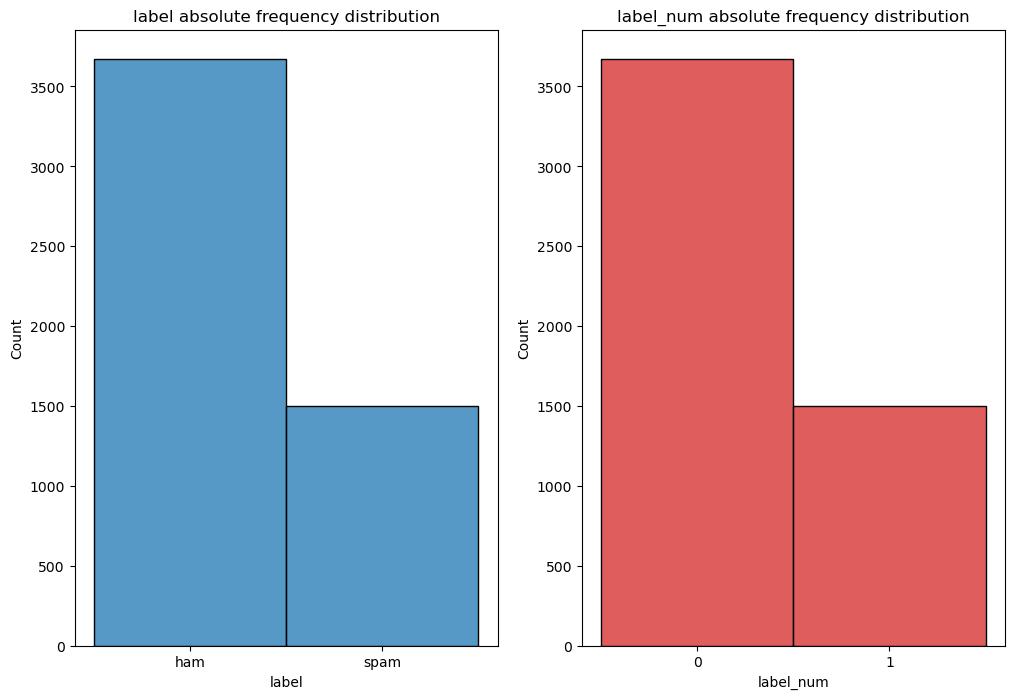

In [5]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
ax = sns.histplot(data=df, x="label",color="tab:blue")
plt.title("label absolute frequency distribution")
plt.subplot(1,2,2,sharey=ax)
sns.histplot(data=df, x="label_num", color="tab:red", discrete=True)
plt.xticks([0,1])
plt.title("label_num absolute frequency distribution")
plt.show()

As one can see - both from `value_counts` and histogram - the distribution of the two features seems to be identical. 

To be more even more confident about one can check if there are "hybrid" records, i.e. records where `label` and `label_num` values aren't one of the two pairs ("ham",0) or ("spam",1): to check it one can compute a bivariate histogram.

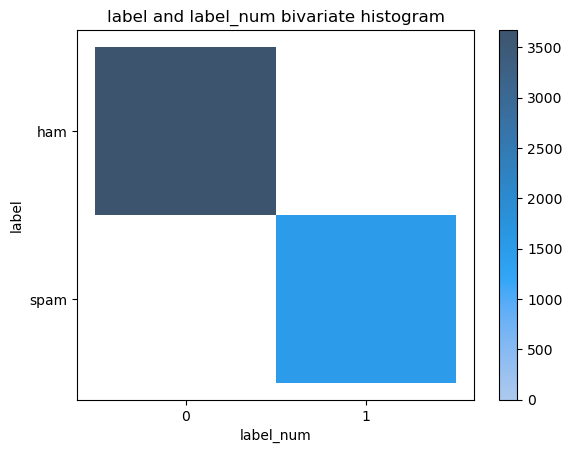

In [6]:
sns.histplot(data=df,x="label_num",y="label",discrete=(True,True),cbar=True)
plt.xticks([0,1])
plt.title("label and label_num bivariate histogram")
plt.show()

The histogram confirms the hypothesis: the two features have same meaning and can be used interchangeably.

In [7]:
print("Proportion between two lables:")
print(df["label"].value_counts(normalize=True))

Proportion between two lables:
label
ham     0.710114
spam    0.289886
Name: proportion, dtype: float64


As last comment about target distribution one sees that the two labels are imbalanced:

the _ham_ (negative) class is more represented than the _spam_ (positive) class ($71\%$ vs $29\%$)

### Text 
Regarding the `text` column, several comments will be shown in below sections, since the underlying information and data will be discovered through tools and models involved in next tasks.

## Text preprocessing
Before moving on with required tasks, a preprocessing must be done on text. With text a suitable preprocessing is crucial, since it helps models to better catch the data information, without getting confused about noise that is often present in a non-structured data like text. 

The preprocessing steps are:
1. Lowercase all the text
2. Remove punctuation
3. Remove english stopwords (taken from [nltk corpora data](https://www.nltk.org/nltk_data/))
4. Lemmatization (through the help of a pretrained model from [spacy lib](https://spacy.io/))
5. Remove numbers (**TODO: check if necessary**)

All these steps aim to get a lighter text (hence less memory required during models' training) without losing meaning-rich words.

In [8]:
# !python -m spacy download en_core_web_sm

In [9]:
aa = [1,2,3,4]
aa

[1, 2, 3, 4]

In [10]:
# aa.append([5,6])
aa.extend([5,6])
aa

[1, 2, 3, 4, 5, 6]

In [11]:
nltk.download("stopwords")
stopwords_en = stopwords.words("english")

#inside stopwords include common words from email domain
stopwords_en.extend(["subject","cc","forwarded","fw"])

#nlp model from spacy
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aless\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def text_clean(sentence:str):
    #lowercase
    sentence = sentence.lower()

    #punctuation
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")
    
    #lemmatization
    doc = nlp(sentence)
    sentence = " ".join(token.lemma_ for token in doc)

    #stopwords - TODO: add "subject" and other words from email domain
    sentence = " ".join(word for word in sentence.split() if word not in stopwords_en)

    #remove numbers
    sentence = re.sub(r"\d","",sentence)

    #remove multiple spaces
    sentence = re.sub(r" +"," ",sentence)
    return sentence

In [13]:
df["text_clean"] = df["text"].apply(text_clean)

df.head(10)

,label,text,label_num,text_clean
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0,enron methanol meter follow note I give monday...
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0,hpl nom january see attached file hplnol xls h...
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0,neon retreat ho ho ho around wonderful time ye...
3,spam,"Subject: photoshop , windows , office . cheap ...",1,photoshop window office cheap main trending ab...
4,ham,Subject: re : indian springs\nthis deal is to ...,0,indian spring deal book teco pvr revenue under...
5,ham,Subject: ehronline web address change\nthis me...,0,ehronline web address change message intend eh...
6,ham,Subject: spring savings certificate - take 30 ...,0,spring saving certificate take save use custom...
7,spam,Subject: looking for medication ? we ` re the ...,1,look medication good source difficult make mat...
8,ham,Subject: noms / actual flow for 2 / 26\nwe agr...,0,nom actual flow agree forward melissa jones te...
9,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0,nomination oct see attached file hplnl xls hpl...


Let's visualize the difference between raw text adn clean text in terms of string lenght: this way one can check how "dirty" was the raw text.

In [14]:
raw_text_len = df["text"].apply(len)
clean_text_len = df["text_clean"].apply(len)

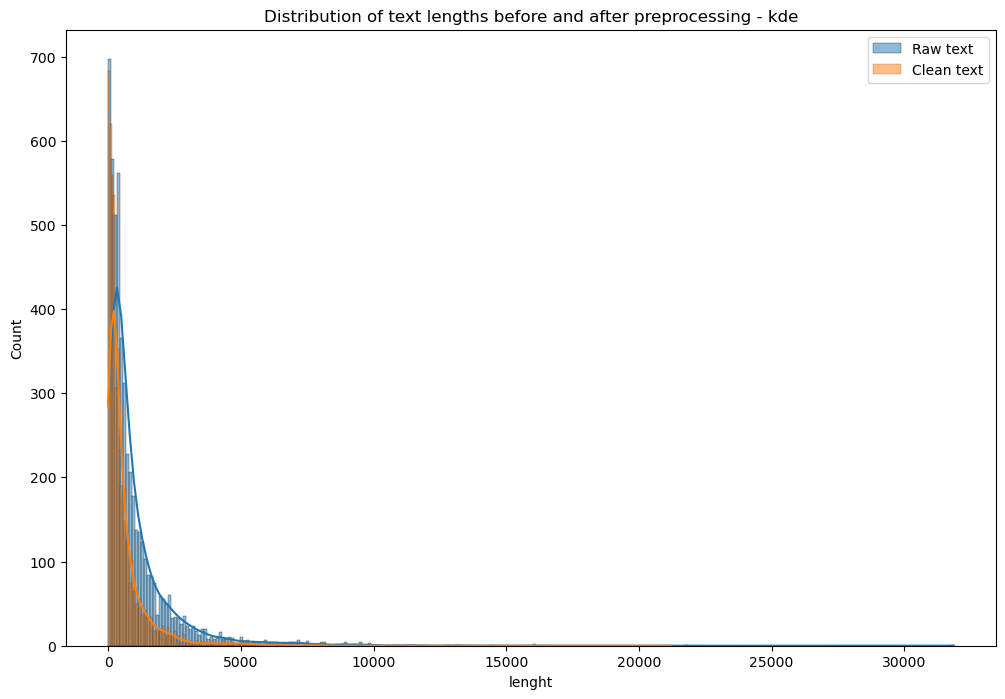

In [15]:
plt.figure(figsize=(12,8))
sns.histplot(x=raw_text_len,kde=True,label="Raw text")
sns.histplot(x=clean_text_len,kde=True,label="Clean text")
plt.legend()
plt.xlabel("lenght")
plt.title("Distribution of text lengths before and after preprocessing - kde")
plt.show()

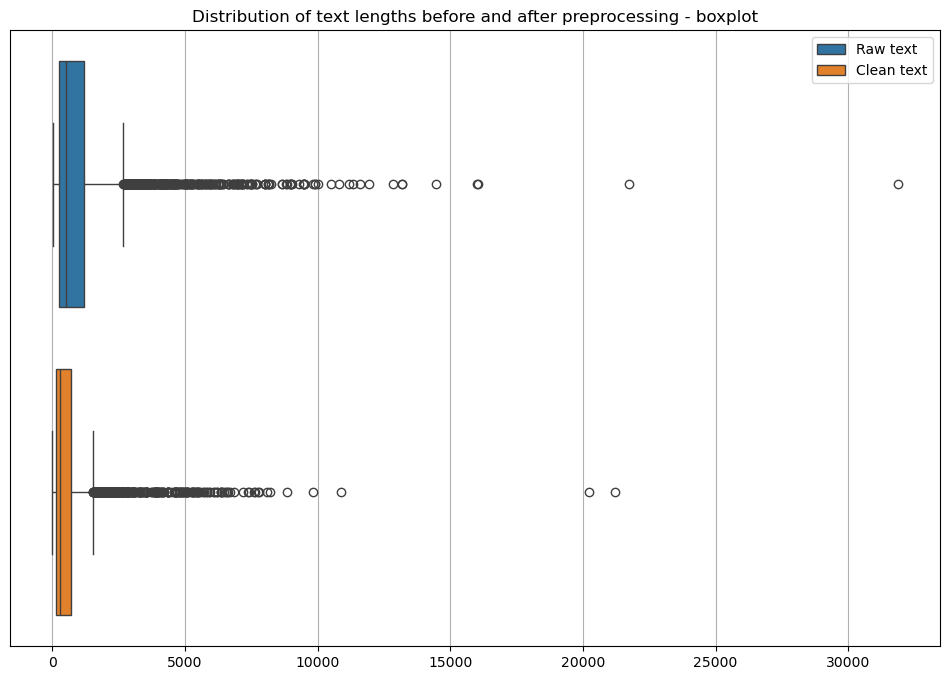

In [16]:
plt.figure(figsize=(12,8))
sns.boxplot(data=[raw_text_len.values, clean_text_len.values], orient="h")
plt.legend(["Raw text","Clean text"])
plt.title('Distribution of text lengths before and after preprocessing - boxplot')
plt.yticks([])
plt.gca().grid(True)
plt.show()

In [17]:
print("Text lenght summary stats:")
#define a temporary dataframe only for visualization purposes
pd.DataFrame([raw_text_len.describe(),clean_text_len.describe()])

Text lenght summary stats:


,count,mean,std,min,25%,50%,75%,max
text,5171.0,1029.745310,1505.103170,10.0,238.0,529.0,1214.0,31860.0
text_clean,5171.0,621.314253,1007.430533,0.0,130.0,299.0,697.0,21223.0


The above charts and dataframe show as the preprocessing was really effective: after cleaning the lenght distribution is shifted towards left (i.e. mean value decreases) and it's more "compressed" (i.e. standard deviation decreases); in other words, several meaningless words and character have been removed (in the most extreme case there is a lenght difference greater than 10k characters!), and this will lead to a lighter model, less affected by noise.

Although the text cleaning is useful, one should note that now there is at least one record with 0 lenght: the minimum lenght value decreases from 10 to 0 after cleaning.

This means that in the original dataset there are records made up of only stopwords or punctuation; it's advisable remove such records, since a string with no characters bring no information. 

According to IQR method there are a lot of outliers in lenght distribution, both before and after cleaning (see dots in boxplots) but without further information about email lenght limits, these data points cannot be considered anomalous, so they're kept as is.


In [18]:
#remove 0 length texts
print(f"There are {(clean_text_len==0).sum()} records with 0 lenght after preprocessing")

df = df[clean_text_len != 0]

#check
df.shape

There are 18 records with 0 lenght after preprocessing


(5153, 4)

## Classification ham - spam

Che classificatore ci metto? 
Bayes?
RNN (e quindi lo sbatti del deep learning)?
Multi layer perceptron?
Altri??

Se uso un approccio bow, il bayesiano viene automatico... O volendo anche la rete neurale (MLP), ma gli altri non molto...
Se uso un embedding, tanto vale usare l'embedding di keras e quindi passare direttamente a rete neurale... Ma non sarà troppa roba con anche le altre cose di mezzo?

Seguiamo approccio semplice e usiamo BOW (da decidere se con tf-idf o count vectorizer) e bayesiano (viva occam).

In [19]:
X = df["text_clean"].values
# y = df["label_num"].values
y = df["label"].values

X_train, X_test, y_train,y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_SEED)

#check
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(4122,)
(1031,)
(4122,)
(1031,)


In [20]:
#vectorizer
vectorizer = CountVectorizer(min_df=0.04)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

#check
print(X_train.shape)
print(X_test.shape)

(4122, 214)
(1031, 214)


### Model

In [21]:
model = ComplementNB()

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.97      0.89      0.93       735
        spam       0.77      0.93      0.84       296

    accuracy                           0.90      1031
   macro avg       0.87      0.91      0.88      1031
weighted avg       0.91      0.90      0.90      1031



In [22]:
from sklearn.naive_bayes import MultinomialNB
model2 = MultinomialNB()

model2.fit(X_train,y_train)
y_pred2 = model2.predict(X_test)

print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

         ham       0.96      0.90      0.93       735
        spam       0.78      0.90      0.83       296

    accuracy                           0.90      1031
   macro avg       0.87      0.90      0.88      1031
weighted avg       0.91      0.90      0.90      1031

